# Building a CNN to Classify Cats and Dogs in Images

## Objective

The objective of this lab is to introduce deep learning and image classification using PyTorch. By the end of this lab, you will be able to:
- Load and preprocess image datasets using PyTorch
- Define and train a basic Convolutional Neural Network (CNN) for image classification
- Evaluate the trained model on test data
- Visualize the model's predictions and analyze its performance
- Experiment with different model architectures and techniques to improve performance

To achieve this objective, we will use a popular image classification task of distinguishing between cats and dogs. This will help you gain hands-on experience with PyTorch's core features, such as the nn module, DataLoader, and optim module. By completing this lab, you will be equipped with the foundational skills necessary to tackle more complex deep learning tasks in the future.

## Step 1: Set up the environment

In this step, we will set up the environment for the lab by importing the necessary libraries.

First, we will import the following libraries:
- PyTorch: A popular deep learning framework for building neural networks.
- NumPy: A Python library for numerical computing.
- Matplotlib: A Python library for data visualization.



In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt


Additionally, we will set the device to run on either the CPU or GPU depending on availability.


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda



This will print out the selected device and ensure that the code runs efficiently on the available resources.

By completing this step, we will have set up the environment with the necessary libraries and device settings for the remainder of the lab.

## Step 2: Load and preprocess the Cats vs Dogs dataset

In this step, we will load and preprocess the Cats vs Dogs dataset using PyTorch.

First, we will download the dataset from a publicly available source.



In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

!unzip -q /tmp/cats_and_dogs_filtered.zip -d cats_vs_dogs

--2024-05-14 05:33:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   127MB/s    in 0.5s    

2024-05-14 05:33:25 (127 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]




Next, we will split the dataset into training and validation sets using PyTorch's `SubsetRandomSampler` class. This ensures that the data is split randomly and that the same images do not appear in both sets.



In [8]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

base_dir = '/content/cats_vs_dogs/cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Let's display some cats and dogs pictures. You can rerun the cell to see a fresh batch each time:

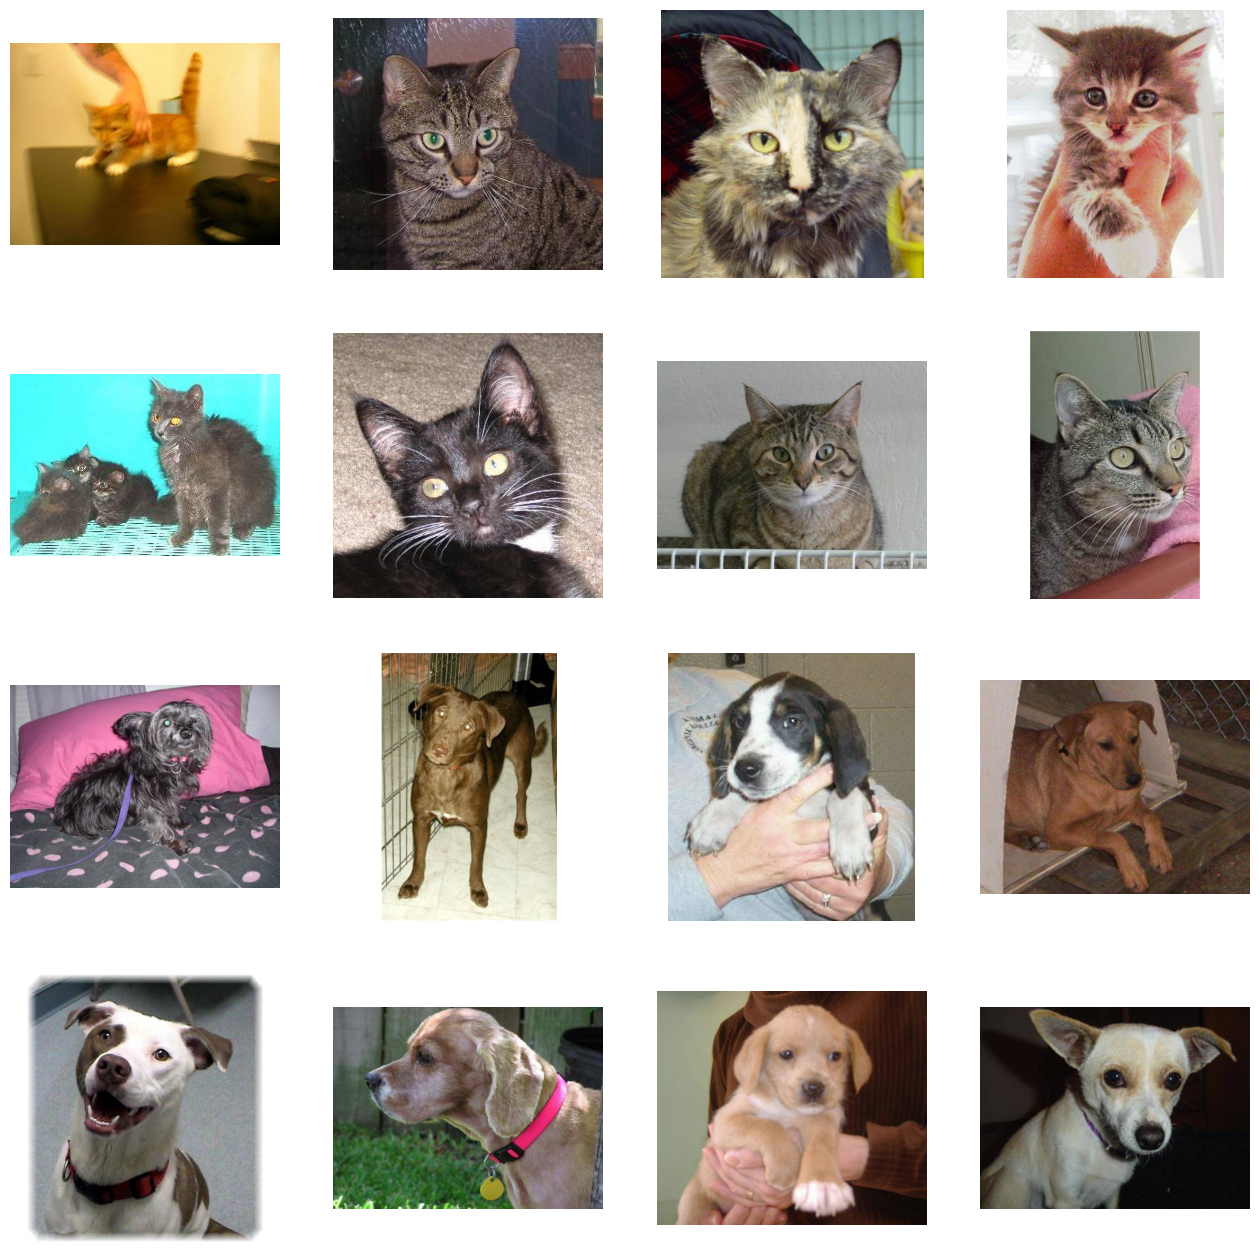

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()



Next, we will preprocess the dataset by normalizing the pixel values and resizing the images to a uniform size.



In [10]:
from torchvision.transforms.transforms import CenterCrop
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

class CatDogDataset(Dataset):

    def __init__(self, mode = "train", transforms = None):
        super().__init__()
        self.mode = mode
        self.transforms = transforms
        if self.mode == "train":
          cats_dir = train_cats_dir
          dogs_dir = train_dogs_dir
          self.main_dir = train_dir
        else:
          cats_dir = validation_cats_dir
          dogs_dir = validation_dogs_dir
          self.main_dir = validation_dir
        cat_fnames = [f"cats/{fn}" for fn in os.listdir(cats_dir)]
        dog_fnames = [f"dogs/{fn}" for fn in os.listdir(dogs_dir)]
        if self.mode == "val":
          cat_fnames = cat_fnames[:300]
          dog_fnames = dog_fnames[:300]
        elif self.mode == "test":
          cat_fnames = cat_fnames[300:]
          dog_fnames = dog_fnames[300:]
        self.img_names = cat_fnames + dog_fnames

    def __getitem__(self, idx):

        image_name = self.img_names[idx]
        img = Image.open(os.path.join(self.main_dir, image_name))
        img = img.resize((224, 224))

        if self.mode == "train" or self.mode == "val":
            ### Preparing class label
            if idx < [1000, 300][self.mode == "val"]:
              label = 0
            else:
              label = 1

            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label

        elif self.mode == "test":

            ### Apply Transforms on image
            img = self.transforms(img)

            return img

    def __len__(self):
        return len(self.img_names)

def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std= [0.229, 0.224, 0.225])
    ])

def get_val_transform():
    return T.Compose([
        # T.CenterCrop(204),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std= [0.229, 0.224, 0.225])
    ])

train_dataset = CatDogDataset(mode = "train", transforms = get_train_transform())
val_dataset = CatDogDataset(mode = "val", transforms = get_val_transform())
test_dataset = CatDogDataset(mode = "test", transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = True
)


By completing this step, we will have loaded and preprocessed the Cats vs Dogs dataset and created PyTorch `DataLoader` objects for efficient data loading during training and evaluation.


## Step 3: Load a CNN for our classification problem

The torchvision.models subpackage contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection, video classification, and optical flow.
Several pre-trained Deep Convolutional Neural Network (*resnet18, resnet50, DenseNet, ConvNeXt*) are explored to predict Cats images versus Dogs ones.
We are going to use [ConvNeXt](https://arxiv.org/pdf/2201.03545).



The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).


In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import convnext_base
from torchvision.models.convnext import LayerNorm2d
from functools import partial

# Load the pre-trained model
model = convnext_base(pretrained = True)

# Modifying Head - classifier
norm_layer = partial(LayerNorm2d, eps=1e-6)
model.classifier = nn.Sequential(
    norm_layer(1024),
    nn.Flatten(1),
    nn.Linear(1024, 1, bias = True),
    nn.Sigmoid()
)

GPU helps to perform the training on large and complex datasets with ease as compared to CPU. So availability of GPU gives advantage on faster training of the model.

In [13]:
from torchsummary import summary

summary(model, (3, 204, 204))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 51, 51]           6,272
       LayerNorm2d-2          [-1, 128, 51, 51]             256
            Conv2d-3          [-1, 128, 51, 51]           6,400
           Permute-4          [-1, 51, 51, 128]               0
         LayerNorm-5          [-1, 51, 51, 128]             256
            Linear-6          [-1, 51, 51, 512]          66,048
              GELU-7          [-1, 51, 51, 512]               0
            Linear-8          [-1, 51, 51, 128]          65,664
           Permute-9          [-1, 128, 51, 51]               0
  StochasticDepth-10          [-1, 128, 51, 51]               0
          CNBlock-11          [-1, 128, 51, 51]               0
           Conv2d-12          [-1, 128, 51, 51]           6,400
          Permute-13          [-1, 51, 51, 128]               0
        LayerNorm-14          [-1, 51, 

## Step 4: Train the model

In this step, we will train the CNN model using the training data and validate its performance on the validation data.

First, we need to define the loss function, optimizer, and evaluation metric for training the model.


In [14]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Loading model to device
model.to(device)

# Number of epochs
epochs = 5

Next, we will iterate over the training data for a certain number of epochs and train the model.

In [16]:
import time
import numpy as np


def accuracy(preds, trues):

    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]

    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]

    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)

    return (acc * 100)


def train_one_epoch(train_data_loader):

    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    model.to(device)
    ###Iterating over data loader
    for images, labels in train_data_loader:

        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape

        #Reseting Gradients
        optimizer.zero_grad()

        #Forward
        preds = model(images)

        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)

        #Backward
        _loss.backward()
        optimizer.step()

    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)

    return epoch_loss, epoch_acc, total_time


def val_one_epoch(val_data_loader, best_val_acc):

    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    ###Iterating over data loader
    for images, labels in val_data_loader:

        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape

        #Forward
        preds = model(images)

        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)

    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)

    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),f"convnet_best.pth")

    return epoch_loss, epoch_acc, total_time, best_val_acc


By running this code, the model will be trained on the training data and its performance will be evaluated on the validation data for each epoch.

In [24]:
# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

best_val_acc = 0
for epoch in range(epochs):

    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)

    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))

    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)

    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

## Step 5: Evaluating training and validation accuracy

Plot results

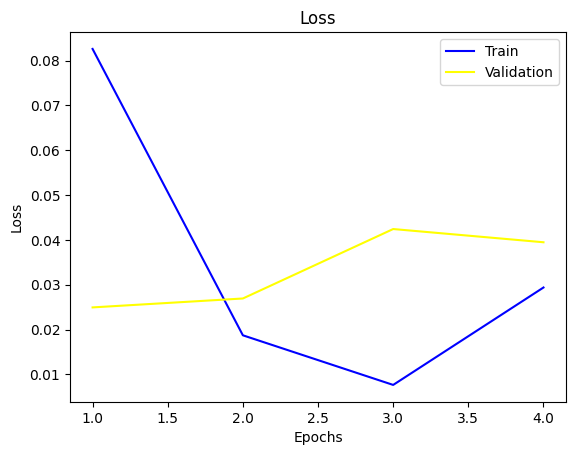

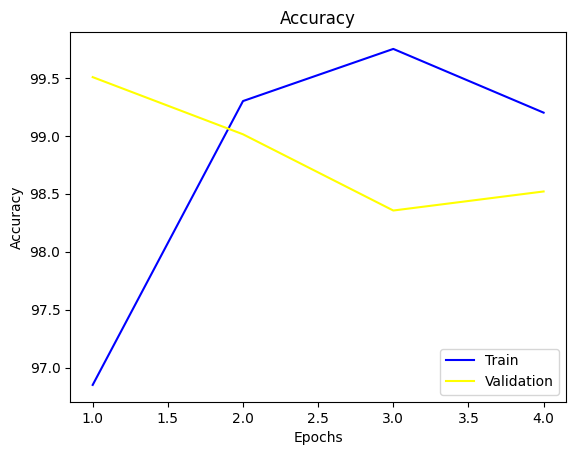

In [22]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, len(train_logs["loss"]) + 1),
         train_logs["loss"], color='blue', label='Train')
plt.plot(np.arange(1, len(val_logs["loss"]) + 1),
         val_logs["loss"], color='yellow', label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, len(train_logs["accuracy"]) + 1),
         train_logs["accuracy"], color='blue', label='Train')
plt.plot(np.arange(1, len(val_logs["accuracy"]) + 1),
         val_logs["accuracy"], color='yellow', label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Step6: Predict a new image loaded from your computer

Use "!wget" to download your image.
> Try to find a misclassified cat or dog, can you find one?

In [40]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Gatto_europeo4.jpg/220px-Gatto_europeo4.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/1/1d/Golden_retriever_stehfoto.jpg?download
!wget https://upload.wikimedia.org/wikipedia/commons/a/a4/2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg

--2024-05-14 05:59:30--  https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Gatto_europeo4.jpg/220px-Gatto_europeo4.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18978 (19K) [image/jpeg]
Saving to: ‘220px-Gatto_europeo4.jpg.3’

220px-Gatto_europeo 100%[===================>]  18.53K  --.-KB/s    in 0.02s   

2024-05-14 05:59:30 (1.12 MB/s) - ‘220px-Gatto_europeo4.jpg.3’ saved [18978/18978]

--2024-05-14 05:59:30--  https://upload.wikimedia.org/wikipedia/commons/1/1d/Golden_retriever_stehfoto.jpg?download
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2161226 (2.1M) [image/jpeg]
Saving to: ‘Golden_r

In [41]:
# List the downloaded files
ll

total 353012
-rw-r--r-- 1 root   6327677 Nov  8  2020  2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg
-rw-r--r-- 1 root     18978 Jun 21  2022  220px-Gatto_europeo4.jpg
-rw-r--r-- 1 root     18978 Jun 21  2022  220px-Gatto_europeo4.jpg.1
-rw-r--r-- 1 root     18978 Jun 21  2022  220px-Gatto_europeo4.jpg.2
-rw-r--r-- 1 root     18978 Jun 21  2022  220px-Gatto_europeo4.jpg.3
drwxr-xr-x 3 root      4096 May 14 05:33  cats_vs_dogs/
-rw-r--r-- 1 root 350397838 May 14 05:45  convnet_best.pth
-rw-r--r-- 1 root     66895 May 14 05:50  File:Golden_retriever_stehfoto.jpg
-rw-r--r-- 1 root     66895 May 14 05:48  File:Golden_retriever_stehfoto.jpg.1
-rw-r--r-- 1 root    123638 May  8 22:31  Golden_retriever
-rw-r--r-- 1 root     66895 May 14 05:32  Golden_retriever_stehfoto.jpg
-rw-r--r-- 1 root   2161226 May 23  2023 'Golden_retriever_stehfoto.jpg?download'
-rw-r--r-- 1 root   2161226 May 23  2023 'Golden_retriever_stehfoto.jpg?download.1'
drwxr-xr-x 1 root      4096 May  9 13:24  sample_dat

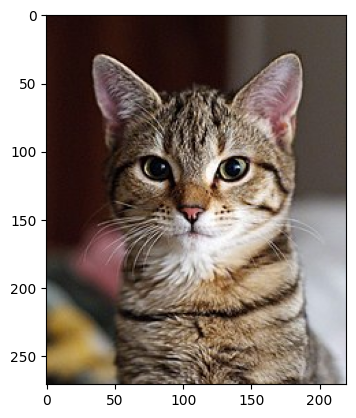

It's a Cat!
Probabilities: Cat=0.999, Dog=0.001


In [52]:
# Plot
name_file = "220px-Gatto_europeo4.jpg"
img = mpimg.imread(name_file)
plt.imshow(img)
plt.show()

# Predict
img = Image.open(name_file)
img = img.resize((224, 224))
transform = get_val_transform()
img = transform(img)
img = torch.unsqueeze(img, 0)
out = model(img.to(device))
print("It's a", "Cat!" if out < 0.5 else "Dog!")
print(f"Probabilities: Cat={1-out.item():.3f}, Dog={out.item():.3f}")

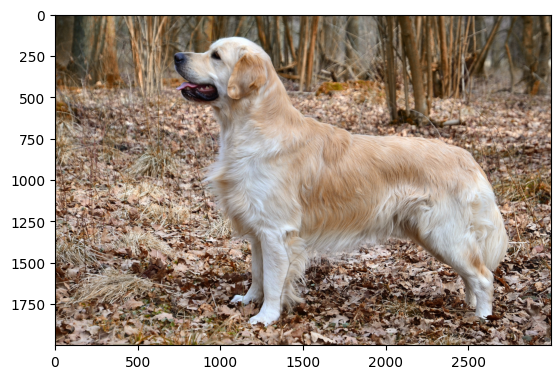

It's a Dog!
Probabilities: Cat=0.000, Dog=1.000


In [53]:
# Plot image
name_file = "Golden_retriever_stehfoto.jpg?download"
img = mpimg.imread(name_file)
plt.imshow(img)
plt.show()

# Predict
img = Image.open(name_file)
img = img.resize((224, 224))
transform = get_val_transform()
img = transform(img)
img = torch.unsqueeze(img, 0)
out = model(img.to(device))
print("It's a", "Cat!" if out < 0.5 else "Dog!")
print(f"Probabilities: Cat={1-out.item():.3f}, Dog={out.item():.3f}")

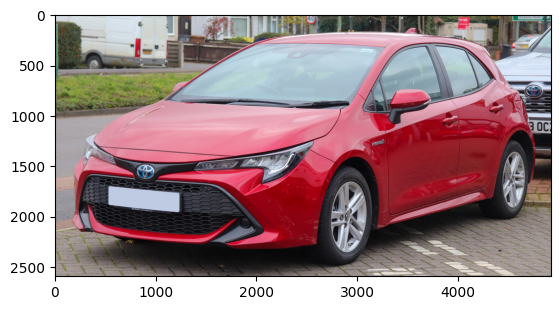

It's a Cat!
Probabilities: Cat=0.961, Dog=0.039


In [48]:
# Plot image
name_file = "2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg"
img = mpimg.imread(name_file)
plt.imshow(img)
plt.show()

# Predict
img = Image.open(name_file)
img = img.resize((224, 224))
transform = get_val_transform()
img = transform(img)
img = torch.unsqueeze(img, 0)
out = model(img.to(device))
print("It's a", "Cat!" if out > 0.5 else "Dog!")
print(f"Probabilities: Cat={out.item():.3f}, Dog={1 - out.item():.3f}")

The Experiment is concluded! :)